In [1]:
import numpy as np

from scipy.io import loadmat
from scipy import optimize

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import NonUniformImage
from matplotlib import cm
matplotlib.style.use('ggplot')
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures

%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(0)

In [3]:
file_path = '../course_materials/ex5data1.mat'

In [4]:
data = loadmat(file_path)
print(type(data))
print(data.keys())
print(data['X'].shape)
print(type(data['X']))
print(data['y'].shape)

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])
(12, 1)
<class 'numpy.ndarray'>
(12, 1)


# 1 Regularised Linear Regression

## 1.1 Data Extraction and Transformation

In [5]:
def get_data(file_path, xLabel, yLabel):
    data = loadmat(file_path)
    X = np.insert(data[xLabel], 0, 1, axis=1)
    n_samples, n_variables = X.shape
    y = data[yLabel]
    return X.flatten(), y.flatten(), n_samples, n_variables

def get_β(n_variables):
    β = np.zeros(n_variables)
    return β

## 1.2 Data Visualisation

In [6]:
def visualiseData(file_path, xLabel, yLabel, title):
    data = loadmat(file_path)
    plt.plot(data[xLabel], data[yLabel], 'o')
    plt.xlabel("Change in water level (x)")
    plt.ylabel("Water flowing out of the dam (y)")
    plt.title(title)
    return plt.show()

### 1.2.1 Training Set

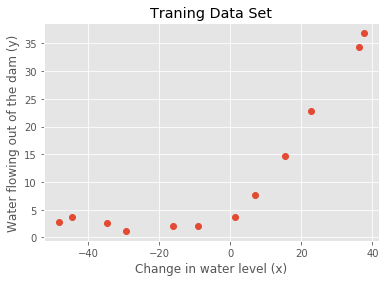

In [7]:
visualiseData(file_path, 'X', 'y', 'Traning Data Set')

### 1.2.2 Validation Set

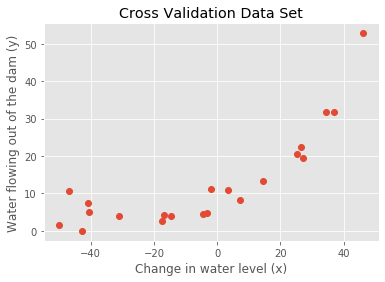

In [8]:
visualiseData(file_path, 'Xval', 'yval', 'Cross Validation Data Set')

### 1.2.3 Test Set

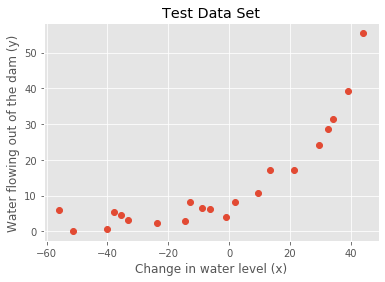

In [9]:
visualiseData(file_path, 'Xtest', 'ytest', 'Test Data Set')

## 1.3 Regularised Linear Regression

**Hypothesis** $h_{\beta}(X) =  X\cdot\beta$

**Error** $e = (h_{\beta}(X) - y)$

**Cost Function** $J = \frac{1}{2n}{\sum(h_{\beta} - y)^2}$

**Regularisation Term** $R = \frac{\lambda}{2n}{\sum{\beta}^2}$

**Regularised Cost** $J = \frac{1}{2n}{\sum(h_{\beta} - y)^2} + \frac{\lambda}{2n}{\sum{\beta}^2}$

**Gradient** $\frac{\partial J}{\partial \beta _0} = \frac{1}{n}X^{T}\cdot e$<br\>
$\frac{\partial J}{\partial \beta _{≠0}} = \frac{1}{n}X^{T}\cdot e + \frac{\lambda}{n}\beta$<br\>

In the code $\frac{\partial J}{\partial \beta}$ is denoted symply as **g**.

In [10]:
def get_hypothesis(β, X, n_samples, n_variables):
    β = β.reshape(n_variables, -1)
    X = X.reshape(n_samples, -1)
#     return hypothesis vector h(n, 1), where n is n_samples
    return np.dot(X, β)

def cost_function(β, X, y, n_samples, n_variables, λ=0.):
    β = β.reshape(n_variables, -1)
    X = X.reshape(n_samples, -1)
    y = y.reshape(n_samples, -1)
#     hypothesis vector h(n, 1)
    h = get_hypothesis(β, X, n_samples, n_variables)
#     cost scalar J(1, 1); technically the result is an array (1,1) rather than a float
    J = np.dot((y-h).T, y-h)/(2*n_samples)
#     similarly cost J can be calculated using np.sum
#     J = np.sum((y-h)**2)/(2*n_samples)
    R = λ*np.dot(β.T, β)/(2*n_samples)
    return (J + R)[0][0]

def get_gradient(β, X, y, n_samples, n_variables, λ=0.):
    β = β.reshape(n_variables, -1)
    X = X.reshape(n_samples, -1)
    y = y.reshape(n_samples, -1)
#     hypothesis vector h(n, 1)
    h = get_hypothesis(β, X, n_samples, n_variables)
#     error vector e(n, 1) = h(n, 1) - y(n, 1)
    e = h - y
#     gradient vector g(k, 1) = X(n, k).T*e(n, 1)*
    g = np.dot(X.T,e)/(n_samples)
#     regularisation term vector (r(400x1)) — derivative of the regularisation term of the cost funtion
    r = β[1:]*(λ/n_samples)
    g[1:] = g[1:] + r
    return g.flatten()

def plot_regression(β, X, y, n_samples, n_variables):  
    β = β.reshape(n_variables, -1)
    X = X.reshape(n_samples, -1)
    y = y.reshape(n_samples, -1)
    
    y_fit = np.dot(X, β)
    
    MSE = np.sum((y - y_fit)**2)/y.shape[0]
    
    plt.plot(X[:,1:], y, 'o', X[:,1:], y_fit, '-')
    plt.xlabel("X")
    plt.ylabel("Y")
    print ("β_0:", β[0][0],
           "\nβ_1:", β[1][0],
           "\nRegression: Y =", '{:10.2f}'.format(β[0][0]), '+', '{:10.2f}'.format(β[1][0]), "X"
           "\nMSE =",'{:10.2f}'.format(MSE))
    return plt.show()

## Function Test
For the trainin set and the $\β$-vector set to ones the output of the functions should be as follows:<br\>
cost_function — J = 303.951525554<br\>
gradient — gradient = [ -15.30301567  598.16741084]

In [11]:
X, y, n_samples, n_variables = get_data(file_path, 'X', 'y')
β = get_β(n_variables)
βOnes = np.ones(n_variables)
# print("hypothesis =", get_hypothesis(β_flatOnes, X_flat, n_samples, n_variables))
J = cost_function(βOnes, X, y, n_samples, n_variables, λ=0.)
print(f"J = {J}")
gradient = get_gradient(βOnes, X, y, n_samples, n_variables, λ=0.)
print(f"gradient = {gradient}")

J = 303.9515255535976
gradient = [-15.30301567 598.16741084]


In [12]:
def optimise_β(β_flat, X_flat, Y_flat, n_samples, n_variables, λ=0.):

    β_optimisation = optimize.minimize(cost_function, β_flat,
                                      args=(X_flat, Y_flat, n_samples, n_variables, λ),
                                      method=None, jac=get_gradient, options={'maxiter':50})
    β_opt = β_optimisation['x']

#     β_optimisation = optimize.fmin_cg(cost_function, fprime=gradient, x0=β_flat,
#                                      args=(X_flat, Y_flat, n_samples, n_variables, λ),
#                                      maxiter=50, disp=False, full_output=True)
#     β_flat = β_optimisation[0]
    return β_opt

In [13]:
β_opt = optimise_β(β, X, y, n_samples, n_variables)
print (f"optimised β {β_opt}")

optimised β [13.08790351  0.36777923]


β_0: 13.087903510869078 
β_1: 0.36777922974565086 
Regression: Y =      13.09 +       0.37 X
MSE =      44.75


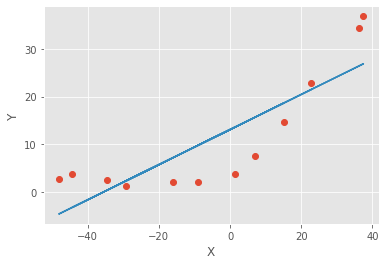

In [14]:
plot_regression(β_opt, X, y, n_samples, n_variables)

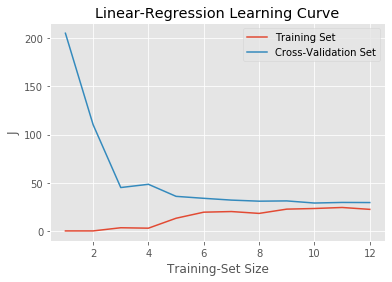

In [15]:
X, y, n_samples, n_variables = get_data(file_path, 'X', 'y')
X_val, y_val, n_samples_val, n_variables_val = get_data(file_path, 'Xval', 'yval')
β = get_β(n_variables)

J_test = []
J_val = []
for i in range(n_samples):
#     np.random.seed(0)
#     indexSet = np.random.choice(n_samples, i+1, replace=False)
#     subsetX = reshapeT(X, n_samples)[indexSet]
#     subsetY = reshapeT(y, n_samples)[indexSet]
    subsetX = X.reshape(n_samples, -1)[:i+1,:]
    subsetY = y.reshape(n_samples, -1)[:i+1]
    flatSubsetX = subsetX.flatten()
    flatSubsetY = subsetY.flatten()
    β_fit = optimise_β(β, flatSubsetX, flatSubsetY, i+1, n_variables)
    y_fit_test = np.dot(subsetX, β_fit)
    J_test += [cost_function(β_fit, flatSubsetX, flatSubsetY, i+1, n_variables, λ=0.)]
    
    y_fit_val = np.dot(X_val.reshape(n_samples_val, -1), β_fit)
    J_val += [cost_function(β_fit, X_val, y_val, n_samples_val, n_variables_val, λ=0.)]

plt.plot(range(1,n_samples + 1), J_test, '-', label='Training Set')
plt.plot(range(1,n_samples + 1), J_val, '-', label='Cross-Validation Set')
plt.xlabel("Training-Set Size")
plt.ylabel("J")
plt.title("Linear-Regression Learning Curve")
plt.legend()
plt.show()

In [16]:
def polynomialsANDinteractions(file_path, xLabel, yLabel, polynomialDegree):
    data = loadmat(file_path)
    X = data[xLabel]
    y = data[yLabel]
    poly = PolynomialFeatures(polynomialDegree)
    poly_X = poly.fit_transform(X)
    n_samples, n_variables = poly_X.shape
    return poly_X.flatten(), y.flatten(), n_samples, n_variables

def normalise(X, n_samples):
    normalisedX = X.reshape(n_samples, -1).copy()
    for i in (range(normalisedX.shape[1])):
        if np.std(normalisedX[:,i]) != 0:
            normalisedX[:,i] = (normalisedX[:,i] - np.mean(normalisedX[:,i]))/np.std(normalisedX[:,i])
    return normalisedX.flatten()

In [17]:
polynomialDegree = 8
poly_X, y, polyn_samples, polyn_variables = polynomialsANDinteractions(file_path, 'X', 'y', polynomialDegree)
poly_β = get_β(polyn_variables)
normPolyX = normalise(poly_X, polyn_samples)
normY = normalise(y, polyn_samples)
print(polyn_samples)
print(polyn_variables)
print(np.max(normPolyX))

12
9
2.889081819926383


[ 4.80289899e-16  8.83572359e-01  1.65030044e+00  1.11363909e+00
 -3.34178136e+00 -3.19209768e+00  2.99447999e+00  2.86241752e+00
 -1.05521662e-01]


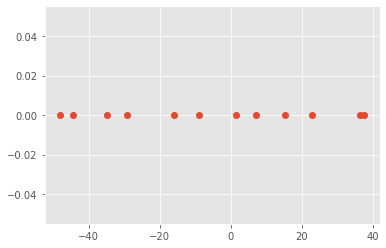

In [18]:
β_opt_poly = optimise_β(poly_β, normPolyX, normY, polyn_samples, polyn_variables)
print (β_opt_poly)
# def plot_regression(β, X, y, n_samples, n_variables):  
poly_β = poly_β.reshape(polyn_variables, -1)
poly_X = poly_X.reshape(n_samples, -1)
y = normY.reshape(n_samples, -1)

y_fit = np.dot(poly_X, poly_β)

MSE = np.sum((y - y_fit)**2)/y.shape[0]

plt.plot(poly_X[:,1:2], y_fit, 'o')
# plt.plot(poly_X[:,1:2], y, 'o', X[:,1:2], y_fit, '-')
# plt.xlabel("X")
# plt.ylabel("Y")
# print ("β_0:", β[0][0],
#        "\nβ_1:", β[1][0],
#        "\nRegression: Y =", '{:10.2f}'.format(β[0][0]), '+', '{:10.2f}'.format(β[1][0]), "X"
#        "\nMSE =",'{:10.2f}'.format(MSE))
plt.show()